In [ ]:
from squlearn.feature_map.qcnn_feature_map import qcnn_feature_map
from squlearn.feature_map.qcnn_feature_map import prototype_routine
from squlearn.util import Executor
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import numpy as np
import itertools
import random
from squlearn.expectation_operator import SingleAmplitude
from squlearn.qnn import QNN
from squlearn.feature_map.layered_feature_map import LayeredFeatureMap
from qiskit.primitives import Estimator
from squlearn.qnn.training import regression
from squlearn.optimizers import SLSQP,Adam
from squlearn.qnn.loss import SquaredLoss
from squlearn.qnn.qnnr import QNNRegressor

In [ ]:
def generate_data_all_combi(length):
    """Creates a 2 dimensional numpy array with all combinations of zeros and ones.
      It outputs this with there labels (0 if more zeros than ones, 1 else)"""
    all_combi_list = list(itertools.product([0,1],repeat=length))
    X_tuple_list = all_combi_list
    X = np.array(X_tuple_list)  #converts list of tuples into a numpy array with dimension 2
    Y = np.count_nonzero(X==0,axis=1) #counts the number of zeros in each sublist
    for i in range(len(Y)):
        zeros = Y[i]
        if 2*zeros > length:
            Y[i] = 0
        else:
            Y[i] = 1 
    return X,Y

def generate_train_data(all_combination_data,train_size):
    """Generates from given all_combination data a train set with there labels."""
    X,Y = all_combination_data[0],all_combination_data[1]
    data_size = Y.size
    index_list = range(data_size)
    index_choice = random.sample(index_list, train_size)
    X_train = np.array([X[i] for i in index_choice])
    Y_train = np.array([Y[i] for i in index_choice])
    return X_train, Y_train



In [ ]:
qubits = 6
train_set_size = 32
#-------------------------------------------------------------------------------------------------------------------------------------------

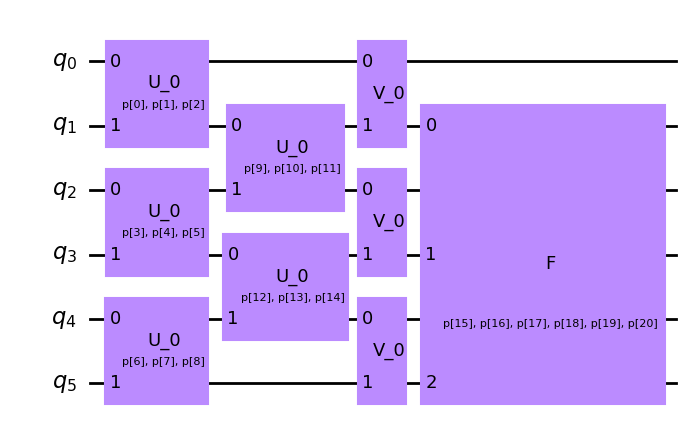

In [24]:
#QCNN feature map with no controlled rotation in convolution layer but with cx for entangling, in fully connected: every qubit rotates differently
qcnn_train = qcnn_feature_map(qubits)

x = ParameterVector("x",6)
conv_gate1 = QuantumCircuit(2)
conv_gate1.rx(x[0],0)
conv_gate1.cx(0,1)
conv_gate1.rx(x[1],1)
conv_gate1.cx(1,0)
conv_gate1.ry(x[2],0)

pool_gate = QuantumCircuit(2)
pool_gate.cy(1,0)

f = ParameterVector("f",6)
fully_gate = QuantumCircuit(3)
fully_gate.rx(f[0],0)
fully_gate.ry(f[1],1)
fully_gate.rz(f[2],2)
fully_gate.crz(f[3],0,1)
fully_gate.crz(f[4],2,1)
fully_gate.rx(f[5],1)

qcnn_train.convolution(conv_gate1,entangled=True,var_param=True)
qcnn_train.pooling(pool_gate)
qcnn_train.fully_connected(fully_gate)

param_vec_for_qcnn = ParameterVector("p", qcnn_train.num_parameters)
qcnn_train.get_circuit([],param_vec_for_qcnn).draw()
#qcnn_train.get_circuit([],param_vec_for_qcnn).decompose().draw()


